# Vehicle Detection

---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

## Import the necessary dependencies

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as cimg
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

#visualizing function
def visualize_images_in_pair(firstImgs,secondImgs,
                             firstTitle=" ", secondTitle=" ",
                             firstCMAP="gray", secondCMAP="gray",
                             figsize=(10,30)):
    # Setup plot
    plt.figure(1,figsize=figsize)
    idx = 0
    plt_cols = 2
    plt_rows = len(firstImgs)

    for img, correctedImg in zip(firstImgs,secondImgs):
        #plot image
        plt.subplot(plt_rows, plt_cols, idx+1)
        plt.imshow(img,cmap=firstCMAP)
        plt.title(firstTitle + ' {}'.format(idx/2),size=15)
        if correctedImg is not None:
            plt.subplot(plt_rows, plt_cols, idx+2)
            plt.imshow(correctedImg,cmap=secondCMAP)
            plt.title(secondTitle + ' {}'.format(idx/2),size=15)
        idx += 2
        
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Retrieve the path of vehicles/non-vehicles images

There are: 
	6 test images
	8792 vehicle images
	8968 non-vehicle images


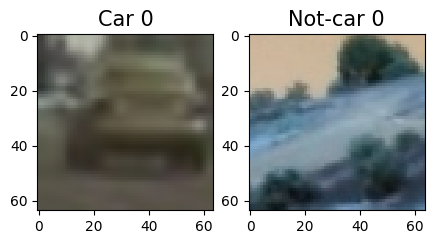

In [2]:
# Make a list of test images
testFolder = './test_images'
testImgPaths = sorted(glob.glob(testFolder + '/*.jpg'))

# Make a list of vehicles images
vehiclesFolder = './train_images/vehicles'
vehiclesImgPaths = sorted(glob.glob(vehiclesFolder + '/*/*.png'))

# Make a list of non-vehicles images
non_vehiclesFolder = './train_images/non-vehicles'
non_vehiclesImgPaths = sorted(glob.glob(non_vehiclesFolder + '/*/*.png'))

print "There are: \n\t{} test images\n\t{} vehicle images\n\t{} non-vehicle images".format(len(testImgPaths),len(vehiclesImgPaths),len(non_vehiclesImgPaths))

#testing
vehicleImage = [ cv2.imread(vehiclesImgPaths[20]).astype(np.float32)/255.]
non_vehicleImage = [ cv2.imread(non_vehiclesImgPaths[244]).astype(np.float32)/255.]
visualize_images_in_pair(vehicleImage,non_vehicleImage,"Car","Not-car",figsize=(5,10))

### Feature extraction functions

/usr/local/lib/python2.7/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


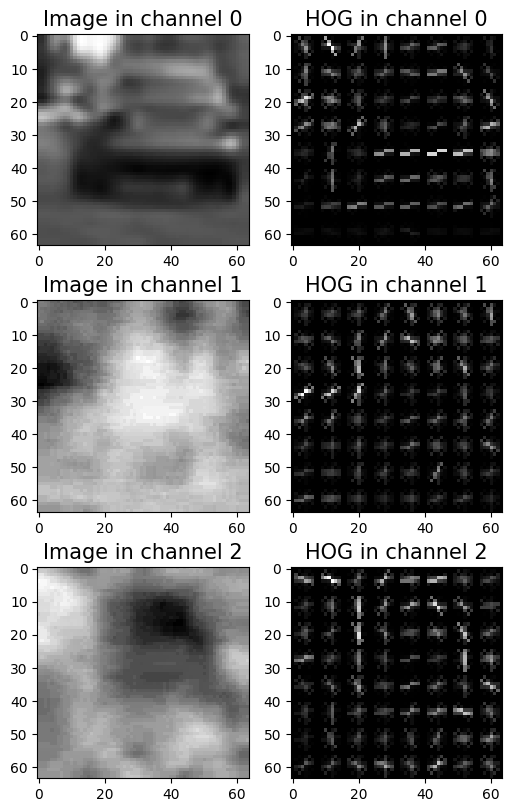

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        if file.split('.')[-1] == 'png':
            image = cimg.imread(file)
        elif file.split('.')[-1] == 'jpg':
            image = cimg.imread(file).astype(np.float32)/255.
        else:
            continue
            
        #image = cv2.imread(file).astype(np.float32) / 255.
        #image[image<0.] = 0.
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
#testing
yuv_img = cv2.cvtColor(vehicleImage[0],cv2.COLOR_BGR2YUV)
hog_imgs = []
color_imgs = []
for i in xrange(3):
    color_imgs.append(yuv_img[:,:,i])
    _, hogImg = get_hog_features(color_imgs[-1],9,8,2,vis=True)
    hog_imgs.append(hogImg)
visualize_images_in_pair(color_imgs,hog_imgs,"Image in channel","HOG in channel",figsize=(6,10))

# Training pipeline

### Extracting features

In [4]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(vehiclesImgPaths, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehiclesImgPaths, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


### Training a classifier

In [5]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 8000)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

('Using:', 9, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 5484)
(14.08, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9834)


### Detecting vehicles in image using sliding windows and hog sub-sampling

scale = [ 1.2   1.35  1.5 ]


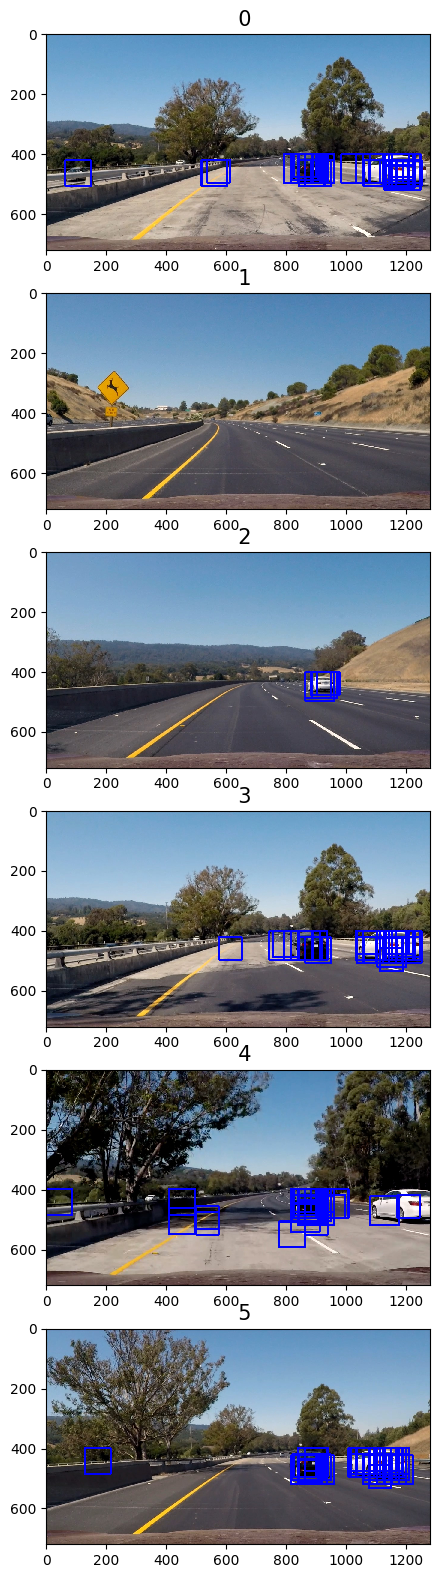

In [6]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img,color_space, 
              ystart, ystop, scale, 
              svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, 
              spatial_feat=False, spatial_size = (None,None), 
              hist_feat=False, hist_bins = None):
    
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)      
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    #Sliding window search
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            file_features = []
            # Get color features
            if spatial_feat == True:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                file_features.append(spatial_features)
            if hist_feat == True:
                # Apply color_hist()
                hist_features = color_hist(subimg, nbins=hist_bins)
                file_features.append(hist_features)
                
            file_features.append(hog_features)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.concatenate(file_features).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                 
                
    return bboxes

ystart = 400
ystop = 656
min_scale = 1.2
max_scale = 1.5
num_scales = 3
scales = np.linspace(min_scale,max_scale,num_scales)
print "scale = {}".format(scales)

imgs = []
bboxes = []
slidingWindowsImgs=[]

for path in testImgPaths:
    img = cimg.imread(path).astype(np.float32) / 255.
    imgs.append(img)
    bboxes_ = []
    #go from min scale to max one
    for scale in scales:
        box_list = find_cars(img,color_space, ystart, ystop, scale, svc, 
                            X_scaler, orient, pix_per_cell, cell_per_block,
                            spatial_feat=spatial_feat, spatial_size = spatial_size,
                            hist_feat=hist_feat, hist_bins = hist_bins)
        bboxes_.extend(box_list)
    bboxes.append(bboxes_)
    draw_img = np.copy(img)
    for bbox in bboxes_:
        cv2.rectangle(draw_img,bbox[0],bbox[1],(0,0,1),6)
    slidingWindowsImgs.append(draw_img)

visualize_images_in_pair(slidingWindowsImgs,secondImgs=[None]*len(slidingWindowsImgs),figsize=(15,20))

### Refining detections

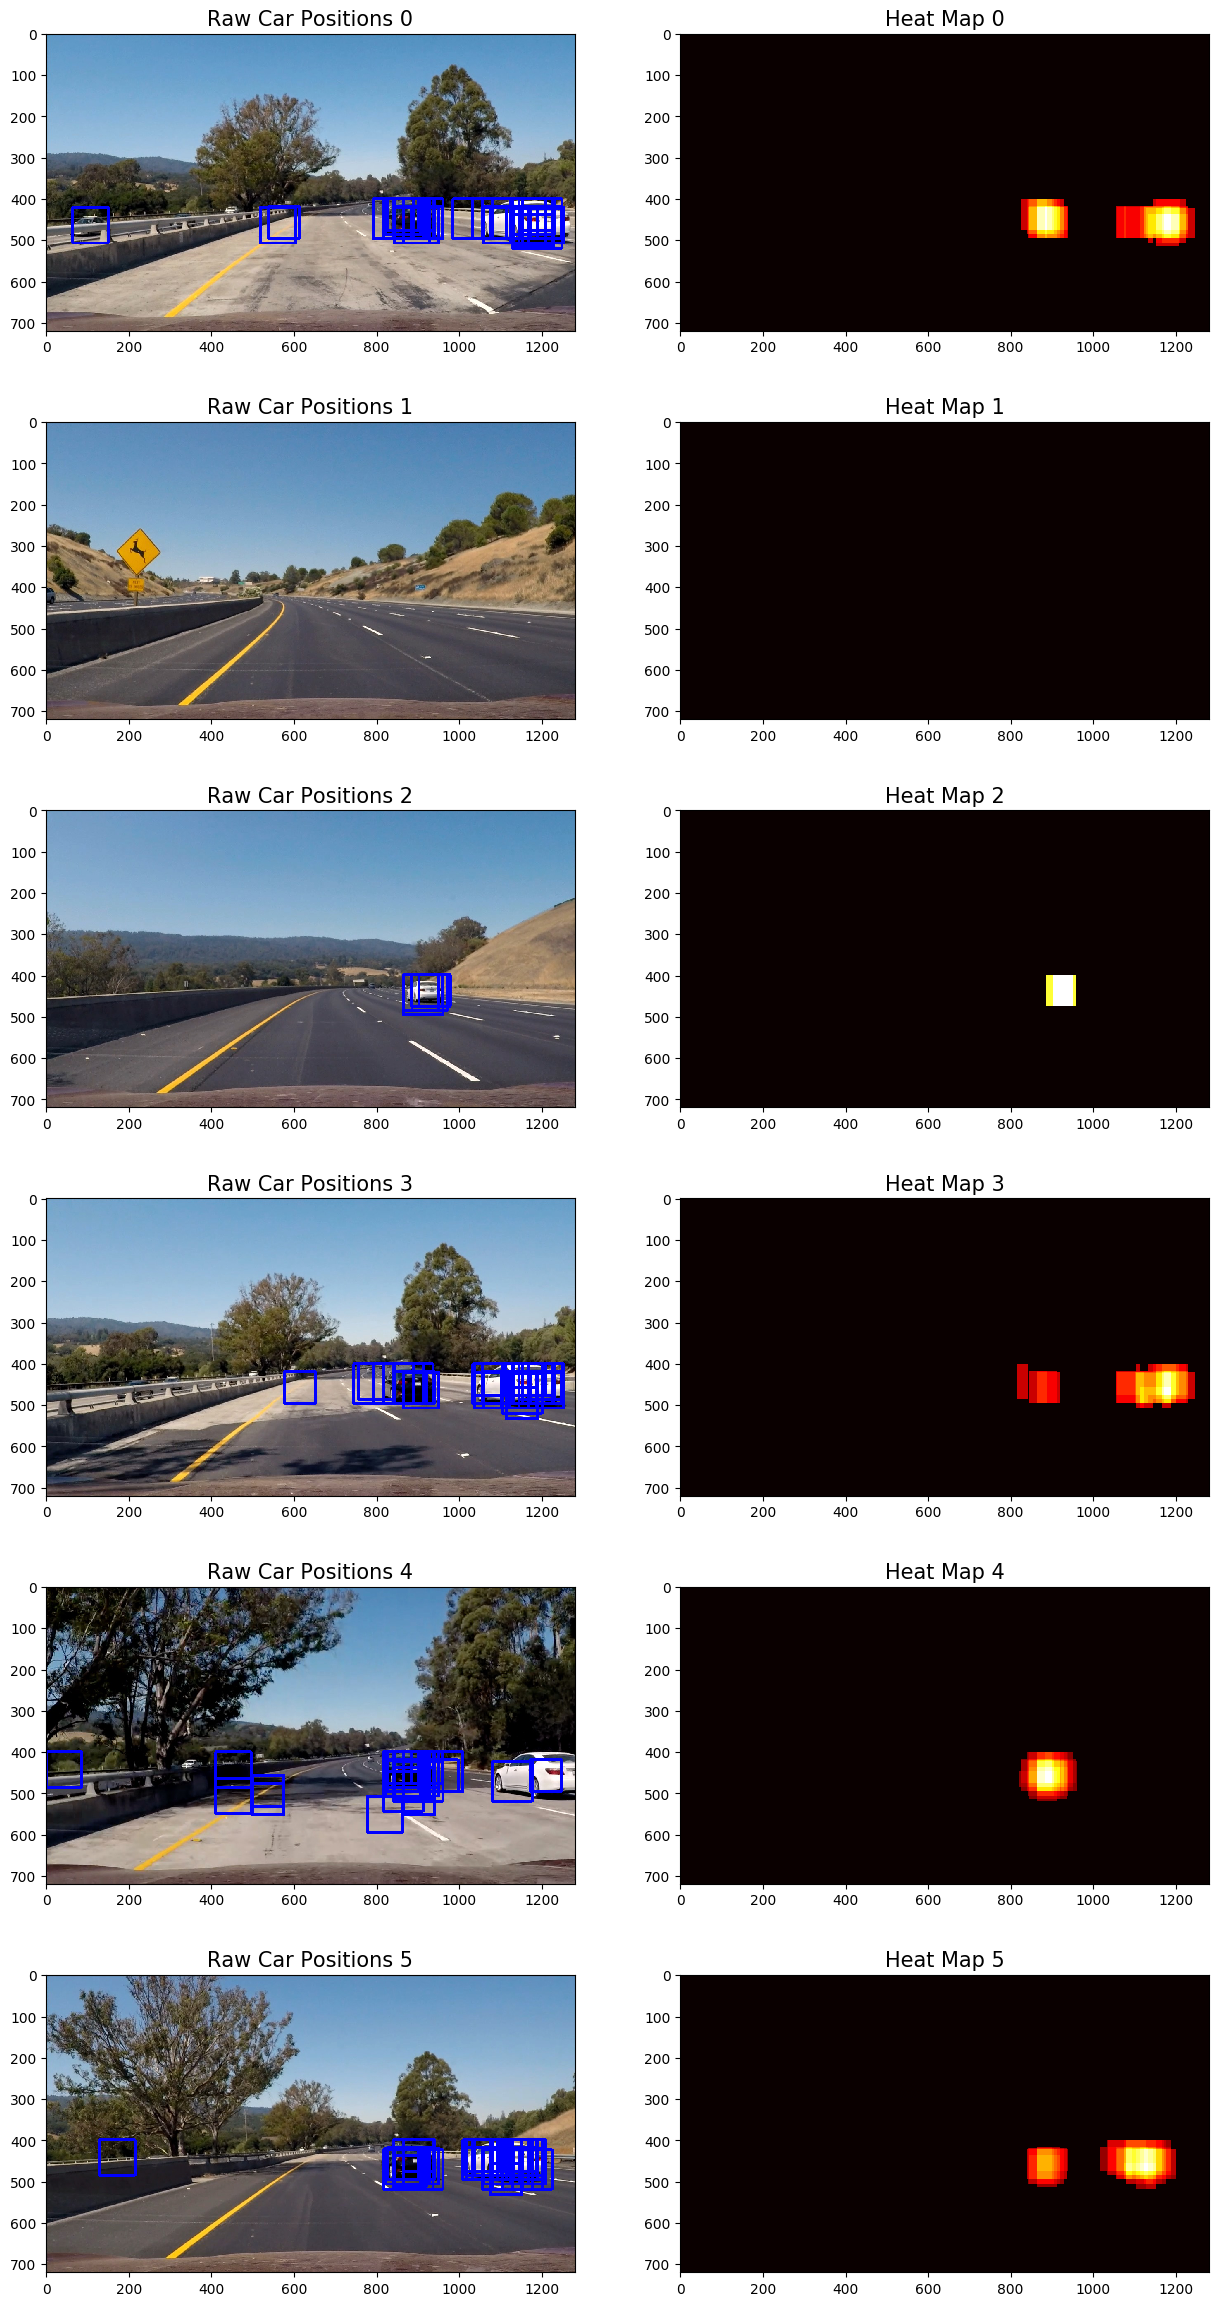

In [7]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,1), 6)
    # Return the image
    return img

draw_imgs = []
heatmaps = []
labels_list = []
for bbox, img in zip(bboxes,imgs):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    heatmaps.append(heatmap)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    draw_imgs.append(draw_img)
    labels_list.append(labels[0])

visualize_images_in_pair(slidingWindowsImgs,heatmaps,'Raw Car Positions','Heat Map','gray','hot',(15,30))


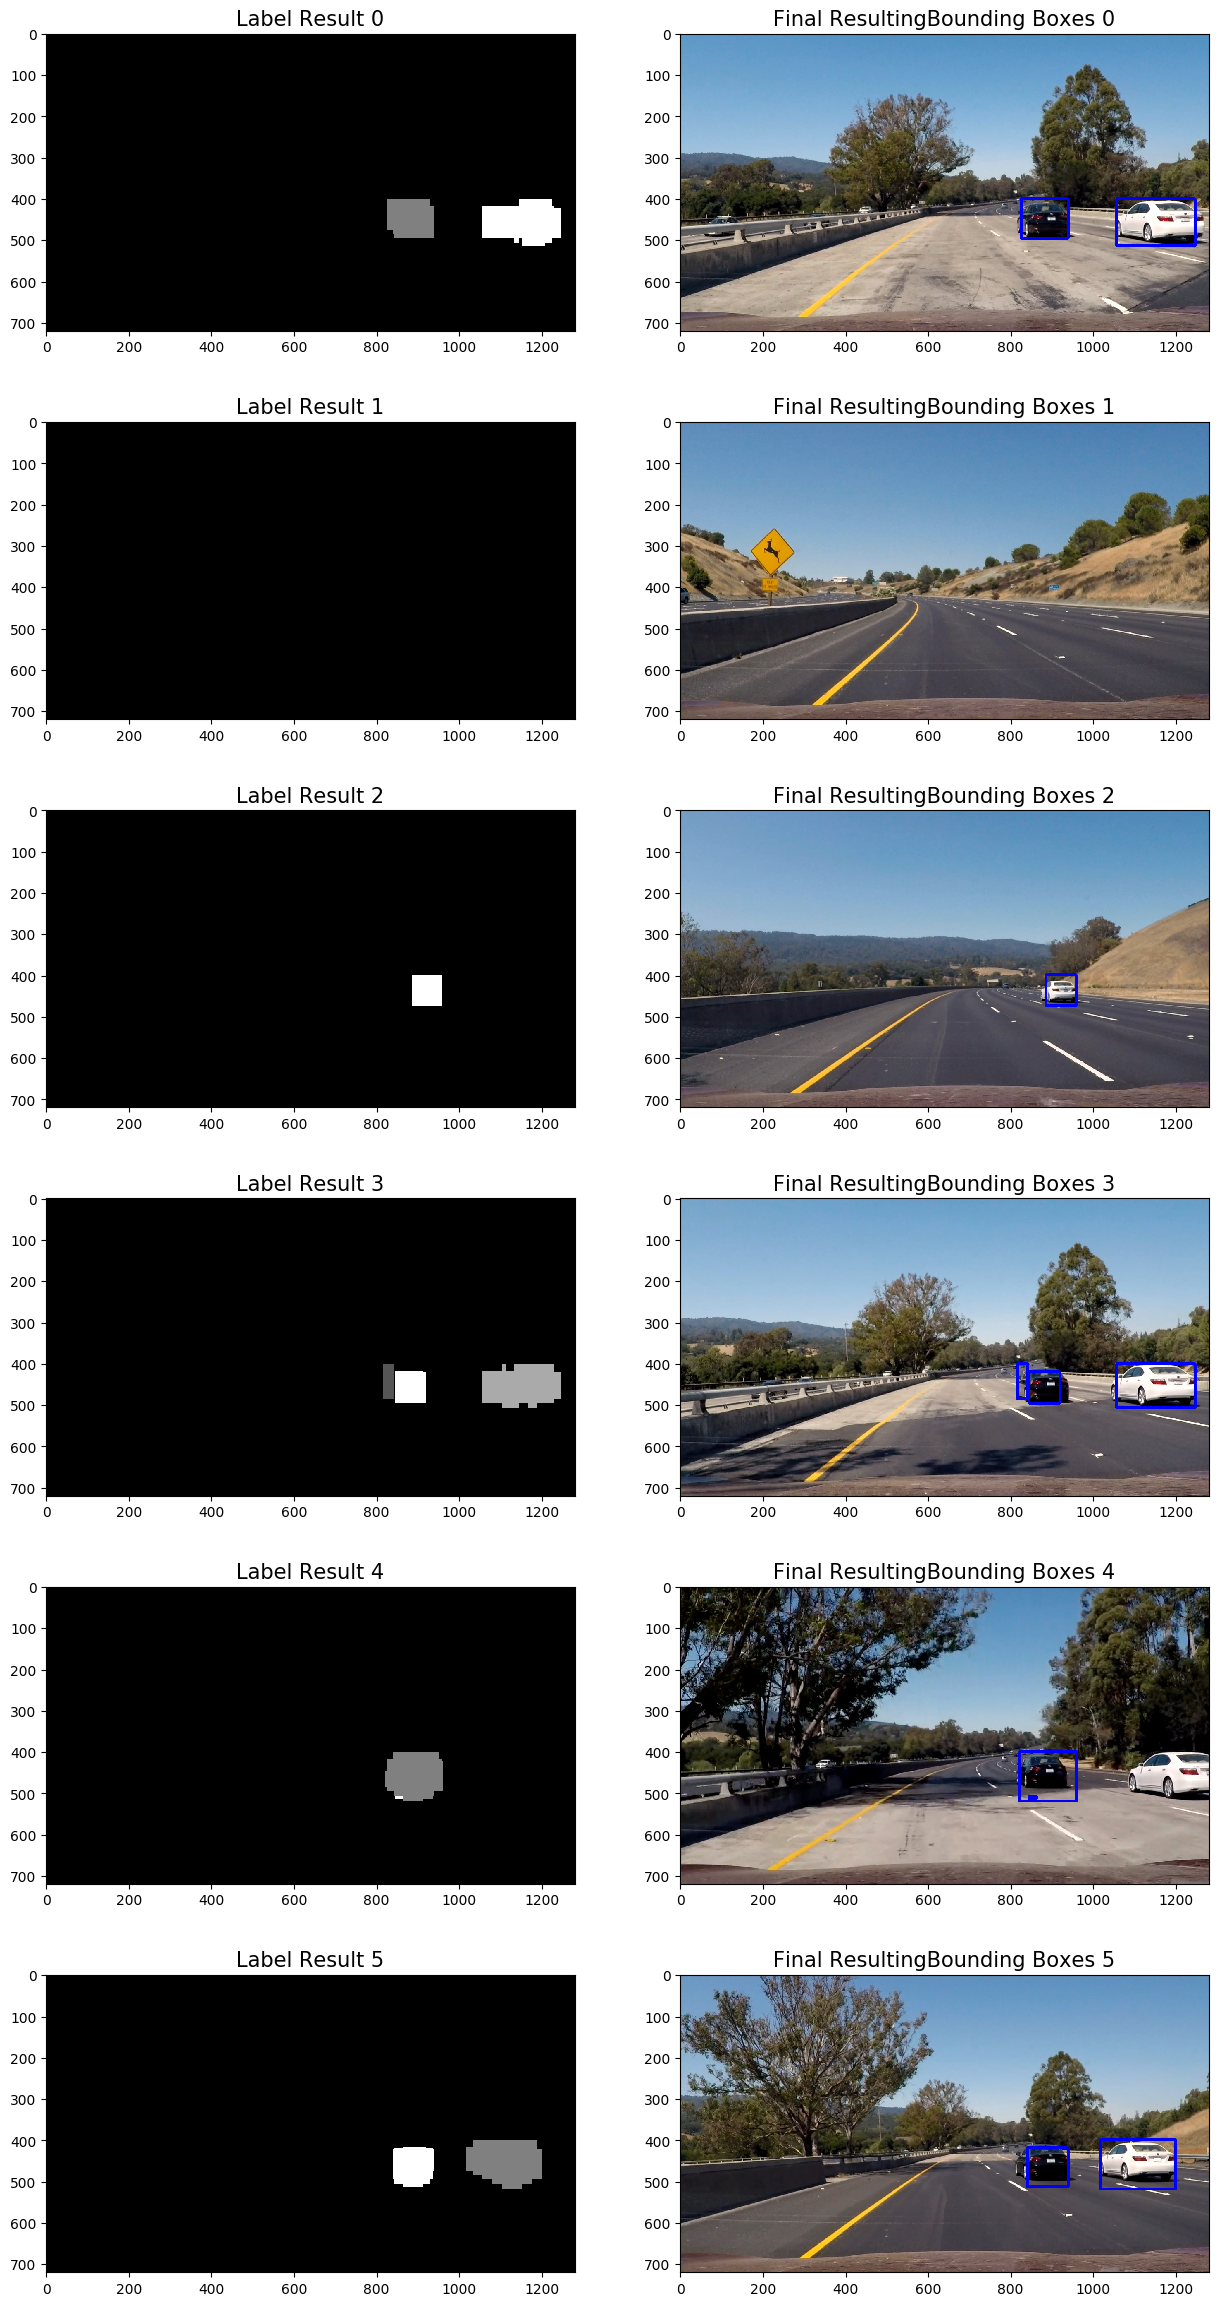

In [8]:
visualize_images_in_pair(labels_list,draw_imgs,'Label Result','Final ResultingBounding Boxes','gray','gray',(15,30))

## Pipeline

In [9]:
ystart = 400
ystop = 656
min_scale = 1.2
max_scale = 1.5
num_scales = 3
num_frames_of_interest = 3
global_count = 0
global_heatmap = [np.zeros([720,1280],dtype=np.float32)]*num_frames_of_interest
def process_image(image,global_count=global_count,global_heatmap=global_heatmap):
    image = image.astype(np.float32)/255.
    
    bboxes = []
    # Detect car at multiple scales
    for i in np.linspace(min_scale,max_scale,num_scales):
        box_list = find_cars(image,color_space, ystart, ystop, i, svc, 
                            X_scaler, orient, pix_per_cell, cell_per_block,
                            spatial_feat=spatial_feat, spatial_size = spatial_size,
                            hist_feat=hist_feat, hist_bins = hist_bins)
        
        bboxes.extend(box_list)
        
    curr_idx = global_count%num_frames_of_interest
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    global_heatmap[curr_idx] = add_heat(heat,bboxes)
    
    acc_heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for heat_ in global_heatmap:
        acc_heat += heat_

    # Apply threshold to help remove false positives
    heat = apply_threshold(acc_heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    global_count += 1
    return draw_img*255


# Video Processing

In [10]:
global_count = 0
global_heatmap = [np.zeros([720,1280],dtype=np.float32)]*num_frames_of_interest
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
white_output = 'detected_vehicle_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video detected_vehicle_video.mp4
[MoviePy] Writing video detected_vehicle_video.mp4


100%|█████████▉| 1260/1261 [20:16<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: detected_vehicle_video.mp4 

CPU times: user 20min 21s, sys: 6.34 s, total: 20min 28s
Wall time: 20min 17s


In [11]:
from IPython.display import HTML
HTML("""
<video width="1024" height="576" controls>
  <source src="{0}">
</video>
""".format(white_output))